# Cooking ingredients recommendation  
## Multi-label classification

* This notebook builds a recommendation system for cooking ingredients using multi-label classification. 
* This notebook is organized as the following
1. Load data  
2. Create neural network for multi-label classification  
3. Evaluate model 
4. Example recommendations

In [1]:
# for mac
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [1]:
# conda environment "recipes"
# Python standard libraries
import ast 
import csv
import os
import pickle
import random
import re
import statistics
import time
from collections import Counter 
from itertools import combinations

# Third party imports 
import h5py
import ijson
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from matplotlib import style
plt.style.use('ggplot')
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Lambda, Dense, Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# custom functions 
import functions as fn

# 1. Load data

## 1(a) Load encoded training and CV data

In [2]:
# load the encoded data
with open("data/ingredient_recommendation/train_encoded.csv", "rb") as f:
    train_encoded = pickle.load(f)
with open("data/ingredient_recommendation/CV_encoded.csv", "rb") as f:
    CV_encoded = pickle.load(f)
with open("data/ingredient_recommendation/test_encoded.csv", "rb") as f:
    test_encoded = pickle.load(f)

## 1(b) Tokenizer

In [3]:
# load tokenizer from preprocessing step
with open('models/tokenizer.pickle', 'rb') as handle:
    t = pickle.load(handle)

# create dictionary from index to words 
index_to_words=dict(map(reversed,t.word_index.items())) 

# number of words
n_words = len(t.word_index)
print('number of words: ', n_words)

number of words:  6712


## 1(c) Prepare arrays X, y

In [4]:
def create_Xy(doc, t, sample_size, n_repeat = 1):
    # Given a list of documents, sample "sample_size" number of ingredients from each document. 
    # Create arrays X and y for neural network training and testing.
    # If a document contains less than "sample_size" ingredients, then skip that document.
    
    """
    --- input ---
    doc: (list of lists) Each doc[i] is a document given by a list of integers (ingredients)
    t: (tokenizer)
    sample_size: (int) number of ingredients to sample from each doc
    n_repeat: (int) number of times to perform the sampling.
    
    --- output ---
    X: (array) representing the ingredients sampled for each document
        X[i][j] = 1 if sampled ingredients of doc[i] contains ingredient j (according to tokenizer t)
    y: (array) representing the ingredients NOT sampled
        y[i][j] = 1 if ingredient j is present in doc[i] but was not sampled
    sample: (list of list) representing the ingredients sampled for each document.
        sample[i] = [i_1, ... , i_k], where i_j is an ingredient sampled for doc[i]
    target: (list of list) representing the ingredients in doc[i] that have not been sampled.
        target[i] = [i_1, ... , i_m], where i_m is an ingredient that hasn't been sampled
    """
    
    sample = []
    target = []
    indices = []
    n_doc = len(doc)
    n_words = len(t.word_index)
    
    for i in range(n_doc):
        recipe = doc[i]
        
        # check that recipe contains more than "sample_size" ingredients
        if len(recipe) > sample_size:
            for j in range(n_repeat):
                random.shuffle(recipe)

                # split to sample & target
                recipe_sample = recipe[:sample_size]
                recipe_target = recipe[sample_size:]
                
                # append
                sample.append(recipe_sample)
                target.append(recipe_target)
                indices.append(i)
            
    # create array X
    X = np.array(sample)
    
    # create array y
    y = np.zeros((len(target), n_words))
    
    for data_idx, target_words in enumerate(target):
        for word_idx in target_words:
            y[data_idx, word_idx] = 1

    return X, y, sample, target, indices

In [5]:
# Create X, y for training 
X_train, y_train, sample_train, target_train, indices_train = create_Xy(train_encoded, t, 5, 5)

# Create X_cv, y_cv for evaluation on cross-validation set
X_cv, y_cv, sampled_cv, target_cv, indices_cv = create_Xy(CV_encoded, t, 5, 1)

# 2. multi-label classification model using neural networks  
* Will use keras to construct neural networks that perform multi-label classification

## 2(a) Define custom metrics and callbacks

<b> Custom metrics </b> 
* keras doesn't have a built-in function for computing precision / recall / F1 scores, so I wrote my own metrics

In [6]:
class MetricsAtK:
    def __init__(self, k):
        self.k = k

    def _prediction_tensor(self, y_pred):
        # Given tensor y_pred of floats (predicted probabilities), 
        # return a tensor of same shape with 1 in locations with "k" top probabilities. 
        y_pred = tf.convert_to_tensor(y_pred)
        topk_indices = tf.nn.top_k(y_pred, k = self.k, sorted = True).indices
        ii, _ = tf.meshgrid(tf.range(tf.shape(y_pred)[0]), tf.range(6), indexing='ij')
        index_tensor = tf.reshape(tf.stack([ii, topk_indices], axis=-1), shape=(-1, 2))
        index_tensor = tf.cast(index_tensor, tf.int64)
        n_nzero = tf.shape(index_tensor)[0]

        sparse = tf.SparseTensor(indices = index_tensor, values=tf.ones(n_nzero), dense_shape=tf.shape(y_pred, out_type=tf.dtypes.int64))
        sparse = tf.sparse.reorder(sparse)
        pred = tf.sparse.to_dense(sparse)
        pred = tf.cast(pred, tf.float32)

        return pred

    def _TP_at_k(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
        # compute true positives for each sample
        pred = self._prediction_tensor(y_pred)

        TP = K.sum(tf.multiply(pred, y_true), axis = 1)
        TP = tf.cast(TP, tf.float32)
        
        return TP
    
    def precision_at_k(self, y_true, y_pred):
        TP = self._TP_at_k(y_true, y_pred)
        precisions = TP / self.k
        
        # compute median
        mid = tf.shape(precisions)[0]//2 + 1
        precision_median = tf.nn.top_k(precisions, mid).values[-1]
        return precision_median
    
    def recall_at_k(self, y_true, y_pred):
        TP = self._TP_at_k(y_true, y_pred)
        y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
        recalls = TP / K.sum(y_true, axis = 1)
        
        # compute median
        mid = tf.shape(recalls)[0]//2 + 1
        recall_median = tf.nn.top_k(recalls, mid).values[-1]
        return recall_median
    
    def F1_at_k(self, y_true, y_pred):
        TP = self._TP_at_k(y_true, y_pred)
        y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
        precisions = TP / self.k
        recalls = TP / K.sum(y_true, axis = 1)
        f1 = (2 * precisions * recalls) / (precisions + recalls + K.epsilon())
        
        # compute median
        mid = tf.shape(f1)[0]//2 + 1
        f1_median = tf.nn.top_k(f1, mid).values[-1]
        return f1_median


<b> Custom callback</b>  
* By default, when keras evaluates the model on batches of training and CV set, and then returns a batch-wide average.  
* The custom callback evaluates the model on the entire CV set. 
* Furthermore, it performs early stopping while monitoring the CV set F1 score. 

In [7]:
class EarlyStoppingAtK(keras.callbacks.Callback):
        
    def __init__(self, X_val, y_val, metrics, patience = 0, verbose = 0):
        super(keras.callbacks.Callback, self).__init__()
        self.Xval = X_val
        self.yval = y_val
        self.metrics = metrics
        self.precisions = []
        self.recalls = []
        self.F1scores = []
        self.patience = patience
        self.verbose = verbose
        self.wait = 0 # number of epochs since the maximum F1 score
        self.max = -np.Inf
        self.best_weights = None
        self.best_epoch = 0
        
    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.Xval, self.yval
        y_pred = np.asarray(self.model.predict(X_val))
        
        # evaluate CV set
        p = self.metrics.precision_at_k(y_val, y_pred).numpy()
        r = self.metrics.recall_at_k(y_val, y_pred).numpy()
        fscore = self.metrics.F1_at_k(y_val, y_pred).numpy()
        
        self.precisions.append(p)
        self.recalls.append(r)
        self.F1scores.append(fscore)
        print(" Validation precision: %.4f, Validation recall: %.4f, Validation F1: %.4f" %(p, r, fscore))
        
        # early stopping
        # If current score is better than historic max
        if fscore > self.max:
            # update 
            self.max = fscore
            self.wait = 0 
            # Record the current weights
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                print("\n Early stopping at epoch ", epoch + 1)
                
                # restore weights from the best_weights
                self.model.set_weights(self.best_weights)
                print("\n Restoring model weights to weights from epoch ", self.best_epoch)
        return 

In [8]:
# function that evaluates the model on CV set 
# & visualizes the distribution of precision, recall, F1 scores
def show_histograms(model, X_cv, y_cv):
    # get 6 most probable ingredients 
    y_pred = model.predict(X_cv)
    n_dataset = y_pred.shape[0]
    pred = []
    for i in range(n_dataset):
        pred_ing = y_pred[i,:].argsort()[::-1][:6].tolist()
        pred.append(pred_ing)

    # for each document in CV set, create a list of missing ingredients (true ingredients)
    missing_ing = []
    for i in range(n_dataset):
        missing_ing.append(np.nonzero(y_cv[i,:])[0].tolist())

    ## compute precision, recall, F-score on the CV set 
    scores = [fn.compute_scores(pred[i], missing_ing[i]) for i in range(len(pred))]

    precisions = [item[0] for item in scores] 
    recalls = [item[1] for item in scores]
    Fscores = [item[2] for item in scores]

    fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
    ax[0].hist(precisions)
    ax[0].set_title('histogram of precision')

    ax[1].hist(recalls)
    ax[1].set_title('histogram of recalls')

    ax[2].hist(Fscores)
    ax[2].set_title('histogram of F-scores')
    plt.show()

    print("Median precision on CV set: ", statistics.median(precisions) )
    print("Median recall on CV set: ", statistics.median(recalls) )
    print("Median F-score on CV set: ", statistics.median(Fscores) )

    print("Mean precision on CV set: ", statistics.mean(precisions) )
    print("Mean recall on CV set: ", statistics.mean(recalls) )
    print("Mean F-score on CV set: ", statistics.mean(Fscores) )

    return  

## 2(b) Model

In [10]:
# define model structure
context_size = 5
embed_size = 100

model = Sequential(name = "model1")

# embedding
model.add(Embedding(n_words, embed_size, input_length = context_size, name = "Embedding"))

# take the mean of vectors
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape = (embed_size,), name = "Mean"))

# last layer
model.add(Dense(n_words, activation = 'sigmoid', name = "Dense"))

#metrics = MetricsAtK(6, X_cv, y_cv)

metrics = MetricsAtK(k = 6)
model.compile(loss =  'binary_crossentropy', optimizer = 'adam', metrics = [metrics.precision_at_k,
                                                                           metrics.recall_at_k,
                                                                           metrics.F1_at_k])
model.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 5, 100)            671200    
_________________________________________________________________
Mean (Lambda)                (None, 100)               0         
_________________________________________________________________
Dense (Dense)                (None, 6712)              677912    
Total params: 1,349,112
Trainable params: 1,349,112
Non-trainable params: 0
_________________________________________________________________


In [11]:
# callbacks for early stopping and model saving
# early stopping
es = EarlyStoppingAtK(X_cv, y_cv, metrics, patience = 5)

# save model
mc = ModelCheckpoint('models/multilabel_NN/model1_{epoch:02d}.h5', save_freq = 'epoch', verbose = 0)

# fit model
history = model.fit(x = X_train, y = y_train, validation_data=(X_cv, y_cv), epochs = 20, verbose = 2, callbacks = [es, mc])

model.save('models/multilabel_NN/model1.h5')

Epoch 1/20
 Validation precision: 0.0000, Validation recall: 0.0000, Validation F1: 0.0000
4098/4098 - 31s - loss: 0.0301 - precision_at_k: 0.0651 - recall_at_k: 0.0335 - F1_at_k: 0.0440 - val_loss: 0.0061 - val_precision_at_k: 0.0505 - val_recall_at_k: 0.0250 - val_F1_at_k: 0.0331
Epoch 2/20
 Validation precision: 0.1667, Validation recall: 0.0909, Validation F1: 0.1176
4098/4098 - 30s - loss: 0.0058 - precision_at_k: 0.0817 - recall_at_k: 0.0447 - F1_at_k: 0.0575 - val_loss: 0.0056 - val_precision_at_k: 0.1124 - val_recall_at_k: 0.0699 - val_F1_at_k: 0.0866
Epoch 3/20
 Validation precision: 0.1667, Validation recall: 0.1429, Validation F1: 0.1538
4098/4098 - 30s - loss: 0.0054 - precision_at_k: 0.1423 - recall_at_k: 0.1009 - F1_at_k: 0.1193 - val_loss: 0.0052 - val_precision_at_k: 0.1629 - val_recall_at_k: 0.1332 - val_F1_at_k: 0.1494
Epoch 4/20
 Validation precision: 0.1667, Validation recall: 0.1875, Validation F1: 0.2000
4098/4098 - 30s - loss: 0.0050 - precision_at_k: 0.1706 - re

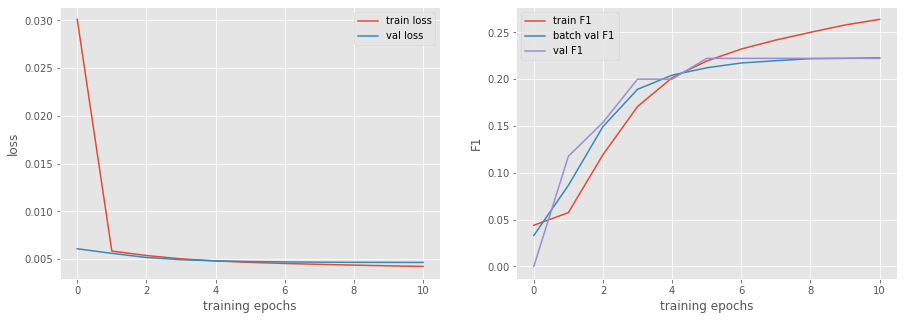

In [12]:
# number of epochs determined by the following
# plot the training and validation loss to determine if overfitting / underfitting 

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_F1 = history.history['F1_at_k']
batch_val_F1 = history.history['val_F1_at_k']
val_F1 = es.F1scores
n_epochs = len(train_loss)

fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
ax[0].plot(list(range(n_epochs)), train_loss, label ='train loss')
ax[0].plot(list(range(n_epochs)), val_loss, label ='val loss')
ax[0].set_xlabel('training epochs')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(list(range(n_epochs)), train_F1, label ='train F1')
ax[1].plot(list(range(n_epochs)), batch_val_F1, label ='batch val F1')
ax[1].plot(list(range(n_epochs)), val_F1, label ='val F1')
ax[1].set_xlabel('training epochs')
ax[1].set_ylabel('F1')
ax[1].legend()
plt.show()

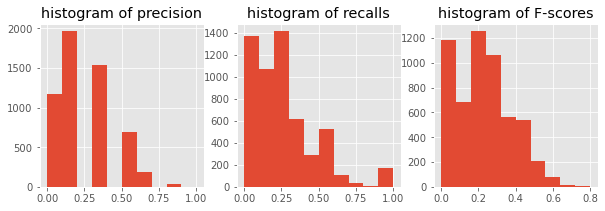

Median precision on CV set:  0.16666666666666666
Median recall on CV set:  0.2
Median F-score on CV set:  0.2222222222222222
Mean precision on CV set:  0.24008574490889603
Mean recall on CV set:  0.24520060612603412
Mean F-score on CV set:  0.21977437167209368


In [13]:
# load model with best performing validation_F1 score
model = keras.models.load_model('models/multilabel_NN/model1.h5', custom_objects= {'precision_at_k':metrics.precision_at_k,
                                                                                  'recall_at_k':metrics.recall_at_k,
                                                                                  'F1_at_k': metrics.F1_at_k})
show_histograms(model, X_cv, y_cv)

## 2(c) models with varying architectures  
* I played around with various architectures of the neural network.  
* In particular, I played around with 
    * Embedding dimension
    * Adding depth (layers) to the neural network 
    * Removing the layer that computes the mean of embedded vectors  
* In the end, adding complexity to the neural network (by increasing dimension or adding hidden layers) did not improve the performance, as measured by F1 score on the CV set. So I decided to use the original architecture from 2(b) since it achieves a good performance without too much complexity (and less training time).
    
* This section shows only one architecture (with a higher embedding dimension and one additional hidden layer). However, one can play around with various architectures in a similar manner.  

In [107]:
# define model architecture
context_size = 5
embed_size = 500
model = Sequential(name = 'model3')

model.add(Embedding(n_words, embed_size, input_length = context_size, name = "Embedding"))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape = (embed_size,), name = "Mean" ))
model.add(Dense(500, activation = 'sigmoid', name = "Dense"))
model.add(Dense(n_words, activation = 'sigmoid'))

metrics = MetricsAtK(k = 6)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [metrics.precision_at_k,
                                                                           metrics.recall_at_k,
                                                                           metrics.F1_at_k])
model.summary()

Model: "model3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 5, 500)            3356000   
_________________________________________________________________
Mean (Lambda)                (None, 500)               0         
_________________________________________________________________
Dense (Dense)                (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 6712)              3362712   
Total params: 6,969,212
Trainable params: 6,969,212
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit model with callbacks
# early stopping
es = EarlyStoppingAtK(X_cv, y_cv, metrics, patience = 5)

# save model
mc = ModelCheckpoint('models/multilabel_NN/model3_{epoch:02d}.h5', save_freq = 'epoch', verbose = 0)

# fit model
history = model.fit(x = X_train, y = y_train, validation_data=(X_cv, y_cv), epochs = 50, verbose = 2, callbacks = [es, mc])

model.save('models/multilabel_NN/model3.h5')

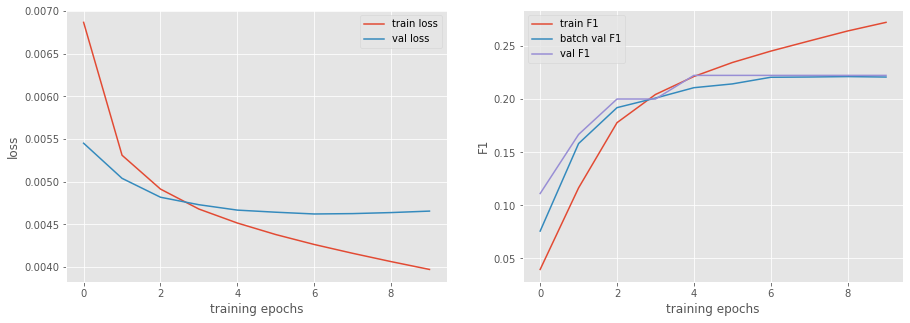

In [109]:
# number of epochs determined by the following
# plot the training and validation loss to determine if overfitting / underfitting 

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_F1 = history.history['F1_at_k']
batch_val_F1 = history.history['val_F1_at_k']
val_F1 = es.F1scores
n_epochs = len(train_loss)

fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
ax[0].plot(list(range(n_epochs)), train_loss, label ='train loss')
ax[0].plot(list(range(n_epochs)), val_loss, label ='val loss')
ax[0].set_xlabel('training epochs')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(list(range(n_epochs)), train_F1, label ='train F1')
ax[1].plot(list(range(n_epochs)), batch_val_F1, label ='batch val F1')
ax[1].plot(list(range(n_epochs)), val_F1, label ='val F1')
ax[1].set_xlabel('training epochs')
ax[1].set_ylabel('F1')
ax[1].legend()
plt.show()

In [110]:
# evaluate 
y_pred = model.predict(X_cv)
print("Validation set precision: ", metrics.precision_at_k(y_cv, y_pred).numpy())
print("Validation set recall: ", metrics.recall_at_k(y_cv, y_pred).numpy())
print("Validation set F1: ", metrics.F1_at_k(y_cv, y_pred).numpy())

Validation set precision:  0.16666667
Validation set recall:  0.2
Validation set F1:  0.22222218


* A more complex architecture did not lead to improvement in performance.  
* Thus, we'll return to the simpler architecture from section 2(b).

## 2(c) Hyperparameter tuning

i. Tune learning rate alpha  
ii. Tune batch size

<b> (i) Learning rate </b>

In [ ]:
# 1. tune learning rate alpha 
# train on a subset of X_train, y_train 
idx = random.sample(range(X_train.shape[0]),50000)
X_sample = X_train[idx,:]
y_sample = y_train[idx,:]
alpha_history = []
alpha_values = []
val_precision = {}
val_recall = {}
val_f1 = {}

for i in range(10):
    # Sample parameter values from log scale, between 0.0003 to 0.03
    alpha_log = np.random.uniform(np.log10(0.0003), np.log10(0.03), 1)[0]
    alpha = round(10**alpha_log,6)

    # Define model structure
    context_size = 5
    embed_size = 100
    model = Sequential(name = "model1")
    model.add(Embedding(n_words, embed_size, input_length = context_size, name = "Embedding"))
    model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape = (embed_size,), name = "Mean"))
    model.add(Dense(n_words, activation = 'sigmoid', name = "Dense"))
    opt = Adam(learning_rate = alpha )
    metrics = MetricsAtK(k = 6)
    model.compile(loss =  'binary_crossentropy', optimizer = opt, metrics = [metrics.precision_at_k,
                                                                               metrics.recall_at_k,
                                                                               metrics.F1_at_k])

    # train 
    es = EarlyStoppingAtK(X_cv, y_cv, metrics, patience = 5)
    history = model.fit(x = X_sample, y = y_sample, validation_data=(X_cv, y_cv), epochs = 20, verbose = 0, callbacks = [es])
    alpha_history.append(history)
    alpha_values.append(alpha)
    
    val_precision[i] = es.precisions
    val_recall[i] = es.recalls
    val_f1[i] = es.F1scores


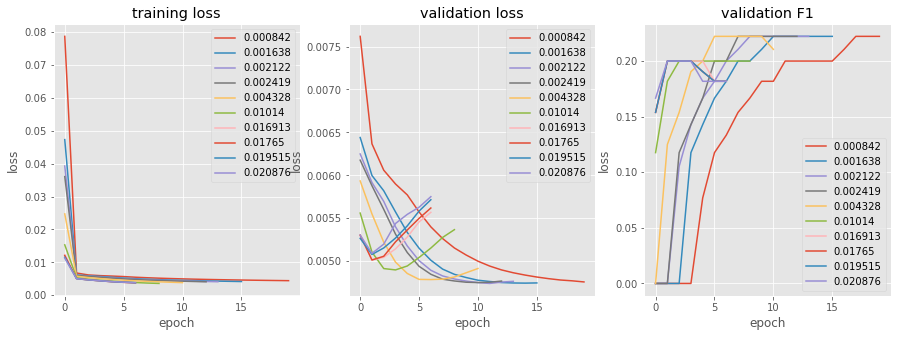

In [174]:
# plot loss curves
fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))
alpha_sort = np.argsort(alpha_values)

for i in range(10):
    train_loss = alpha_history[alpha_sort[i]].history['loss']
    ax[0].plot(train_loss, label=alpha_values[alpha_sort[i]])
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(loc = 'upper right')
ax[0].set_title('training loss')

for i in range(10):
    cv_loss = alpha_history[alpha_sort[i]].history['val_loss']
    ax[1].plot(cv_loss, label=alpha_values[alpha_sort[i]])
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc = 'upper right')
ax[1].set_title('validation loss')

for i in range(10):
    f1 = val_f1[alpha_sort[i]]
    ax[2].plot(f1, label=alpha_values[alpha_sort[i]])
ax[2].set_ylabel('validation F1')
ax[2].set_xlabel('epoch')
ax[2].legend(loc = 'lower right')
ax[2].set_title('validation F1')
plt.show()

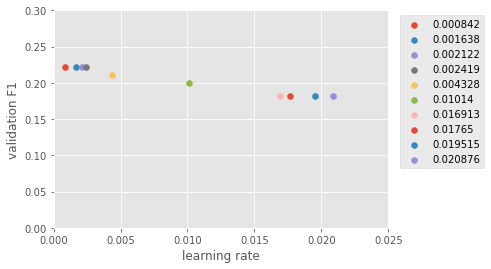

In [178]:
# plot alpha values and val F1 score at the end of training

alpha_sort = np.argsort(alpha_values)
for i in range(10):
    plt.scatter(alpha_values[alpha_sort[i]], val_f1[alpha_sort[i]][-1],
               label = alpha_values[alpha_sort[i]])
plt.xlim(0,0.025)
plt.ylim(0,0.3)
plt.xlabel('learning rate')
plt.ylabel('validation F1')
plt.legend(loc = 'upper right', bbox_to_anchor=(1.3, 1))
plt.show()

*  The above is showing us that the smaller learning rates will reach better Validation F1 performance
* We'll thus choose the (largest) learning rate that whose validation loss doesn't increase too quickly
* choose rate of alpha = 0.002

<b> (ii) Tune batch size </b>

In [ ]:
batch_size = [10, 20, 40, 60, 80, 100]

# train on a subset of X_train, y_train
idx = random.sample(range(X_train.shape[0]),50000)
X_sample = X_train[idx,:]
y_sample = y_train[idx,:]

val_precision = {}
val_recall = {}
val_f1 = {}

metrics = MetricsAtK(k = 6)

for batch in batch_size:

    # Define model structure
    context_size = 5
    embed_size = 100
    model = Sequential(name = "model1")
    model.add(Embedding(n_words, embed_size, input_length = context_size, name = "Embedding"))
    model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape = (embed_size,), name = "Mean"))
    model.add(Dense(n_words, activation = 'sigmoid', name = "Dense"))
    opt = Adam(learning_rate = 0.002)
    model.compile(loss =  'binary_crossentropy', optimizer = opt, metrics = [metrics.precision_at_k,
                                                                               metrics.recall_at_k,
                                                                               metrics.F1_at_k])

    # train 
    es = EarlyStoppingAtK(X_cv, y_cv, metrics, patience = 5)
    history = model.fit(x = X_sample, y = y_sample, validation_data=(X_cv, y_cv), 
                        batch_size = batch,epochs = 50, verbose = 0, callbacks = [es])

    val_precision[batch] = es.precisions
    val_recall[batch] = es.recalls
    val_f1[batch] = es.F1scores

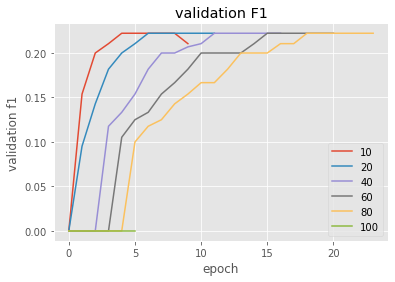

In [185]:
for i in batch_size:
    f1 = val_f1[i]
    plt.plot(f1, label=i)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation F1")
plt.title("validation F1")
plt.show()

* The above graph shows us that a wide range of batch sizes less than 100 would be appropriate. 
* We'll choose the default batch size of 32.

# 3. Evaluation on CV set

In [186]:
# define model structure
context_size = 5
embed_size = 100

model = Sequential(name = "model")

# embedding
model.add(Embedding(n_words, embed_size, input_length = context_size, name = "Embedding"))

# take the mean of vectors
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape = (embed_size,), name = "Mean"))

# last layer
model.add(Dense(n_words, activation = 'sigmoid', name = "Dense"))

metrics = MetricsAtK(k = 6)
opt = Adam(learning_rate = 0.002 )
model.compile(loss =  'binary_crossentropy', optimizer = opt, metrics = [metrics.precision_at_k,
                                                                           metrics.recall_at_k,
                                                                           metrics.F1_at_k])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 5, 100)            671200    
_________________________________________________________________
Mean (Lambda)                (None, 100)               0         
_________________________________________________________________
Dense (Dense)                (None, 6712)              677912    
Total params: 1,349,112
Trainable params: 1,349,112
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# callbacks for early stopping and model saving
# early stopping
es = EarlyStoppingAtK(X_cv, y_cv, metrics, patience = 5)

# save model
mc = ModelCheckpoint('models/multilabel_NN/model_{epoch:02d}.h5', save_freq = 'epoch', verbose = 0)

# fit model
history = model.fit(x = X_train, y = y_train, validation_data=(X_cv, y_cv), 
                    batch_size = 32, epochs = 20, verbose = 2, callbacks = [es, mc])

model.save('models/multilabel_NN/model.h5')

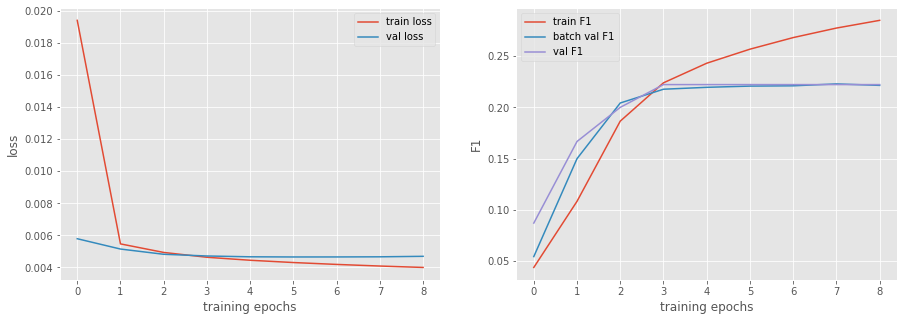

In [188]:
# number of epochs determined by the following
# plot the training and validation loss to determine if overfitting / underfitting 

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_F1 = history.history['F1_at_k']
batch_val_F1 = history.history['val_F1_at_k']
val_F1 = es.F1scores
n_epochs = len(train_loss)

fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
ax[0].plot(list(range(n_epochs)), train_loss, label ='train loss')
ax[0].plot(list(range(n_epochs)), val_loss, label ='val loss')
ax[0].set_xlabel('training epochs')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(list(range(n_epochs)), train_F1, label ='train F1')
ax[1].plot(list(range(n_epochs)), batch_val_F1, label ='batch val F1')
ax[1].plot(list(range(n_epochs)), val_F1, label ='val F1')
ax[1].set_xlabel('training epochs')
ax[1].set_ylabel('F1')
ax[1].legend()
plt.show()

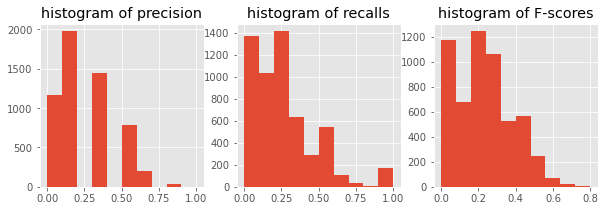

Median precision on CV set:  0.16666666666666666
Median recall on CV set:  0.2
Median F-score on CV set:  0.2222222222222222
Mean precision on CV set:  0.24300345361438608
Mean recall on CV set:  0.24680057071114525
Mean F-score on CV set:  0.22204943621825077


In [9]:
# load model with best performing validation_F1 score
metrics = MetricsAtK(k = 6)
model = keras.models.load_model('models/multilabel_NN/model.h5', custom_objects= {'precision_at_k':metrics.precision_at_k,
                                                                                  'recall_at_k':metrics.recall_at_k,
                                                                                  'F1_at_k': metrics.F1_at_k})
show_histograms(model, X_cv, y_cv)

# 4. Example recommendations

In [10]:
y_pred = model.predict(X_cv)
n_dataset = y_pred.shape[0]
pred = []
for i in range(n_dataset):
    pred_ing = y_pred[i,:].argsort()[::-1][:6].tolist()
    pred.append(pred_ing)

# for each document in CV set, create a list of missing ingredients (true ingredients)
missing_ing = []
for i in range(n_dataset):
    missing_ing.append(np.nonzero(y_cv[i,:])[0].tolist())

## compute precision, recall, F-score on the CV set 
scores = [fn.compute_scores(pred[i], missing_ing[i]) for i in range(len(pred))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

In [191]:
# print examples with high F scores 
highF = np.argsort(Fscores)[::-1][:10]
print(" ********** Example recommendations with high F scores **********")
for i in highF:
    print("==================== Example with F-score: %0.2f ===================="  %Fscores[i])
    print("---------- Existing ingredients ---------- \n", [index_to_words[item+1] for item in sampled_cv[i]])
    print("---------- Missing ingredients ---------- \n", [index_to_words[item+1] for item in target_cv[i]])
    print("---------- Recommended ingredients ---------- \n", [index_to_words[item+1] for item in pred[i]] ,"\n")

 ********** Example recommendations with high F scores **********
==================== Example with F-score: 0.83 ====================
---------- Existing ingredients ---------- 
 ['baking_soda', 'kosher_salt', 'sugar', 'whole_milk', 'buttermilk']
---------- Missing ingredients ---------- 
 ['all-purpose_flour', 'cornmeal', 'large_eggs', 'southern_us', 'baking_powder', 'unsalted_butter']
---------- Recommended ingredients ---------- 
 ['all-purpose_flour', 'southern_us', 'unsalted_butter', 'large_eggs', 'baking_powder', 'irish'] 

==================== Example with F-score: 0.80 ====================
---------- Existing ingredients ---------- 
 ['baking_soda', 'quick-cooking_oats', 'unsalted_butter', 'british', 'baking_powder']
---------- Missing ingredients ---------- 
 ['sugar', 'large_eggs', 'all-purpose_flour', 'buttermilk']
---------- Recommended ingredients ---------- 
 ['all-purpose_flour', 'sugar', 'large_eggs', 'buttermilk', 'eggs', 'baking_soda'] 

==================== Example 

In [192]:
# print examples with low F scores 
lowF = np.argsort(Fscores)[:10]
print(" ********** Example recommendations with low F scores **********")
for i in lowF:
    print("==================== Example with F-score: %0.2f ===================="  %Fscores[i])
    print("---------- Existing ingredients ---------- \n", [index_to_words[item+1] for item in sampled_cv[i]])
    print("---------- Missing ingredients ---------- \n", [index_to_words[item+1] for item in target_cv[i]])
    print("---------- Recommended ingredients ---------- \n", [index_to_words[item+1] for item in pred[i]] ,"\n")

 ********** Example recommendations with low F scores **********
==================== Example with F-score: 0.00 ====================
---------- Existing ingredients ---------- 
 ['italian', 'olive_oil', 'potatoes', 'red_pepper_flakes', 'bacon']
---------- Missing ingredients ---------- 
 ['feta_cheese_crumbles', 'salt_and_ground_black_pepper', 'eggs', 'sweet_pepper']
---------- Recommended ingredients ---------- 
 ['onions', 'garlic', 'pepper', 'ground_black_pepper', 'water', 'garlic_cloves'] 

==================== Example with F-score: 0.00 ====================
---------- Existing ingredients ---------- 
 ['basil', 'puff_pastry', 'italian', 'part-skim_mozzarella_cheese', 'fresh_basil']
---------- Missing ingredients ---------- 
 ['cooking_spray']
---------- Recommended ingredients ---------- 
 ['olive_oil', 'grated_parmesan_cheese', 'garlic', 'fresh_basil', 'garlic_cloves', 'eggs'] 

==================== Example with F-score: 0.00 ====================
---------- Existing ingredients 

In [13]:
# are there any systematic underperformance for particular cuisine? 
df_CV = df.loc[cv_idx]
df_CV.reset_index(inplace = True)

df_CV = df_CV.loc[indices_cv]
df_CV.reset_index(inplace = True)

df_CV["precisions"] = precisions
df_CV["recalls"] = recalls
df_CV["Fscores"] = Fscores

# compute median scores for each cuisine
CV_scores = df_CV[["cuisine", "precisions", "recalls", "Fscores"]].groupby("cuisine").median().sort_values(by='Fscores', ascending = False)
CV_scores

,precisions,recalls,Fscores
cuisine,,,
chinese,0.333333,0.230769,0.266667
filipino,0.166667,0.250000,0.250000
korean,0.250000,0.250000,0.250000
greek,0.166667,0.222222,0.235294
indian,0.333333,0.200000,0.235294
russian,0.166667,0.250000,0.222222
irish,0.166667,0.250000,0.222222
italian,0.166667,0.250000,0.222222
southern_us,0.166667,0.250000,0.222222


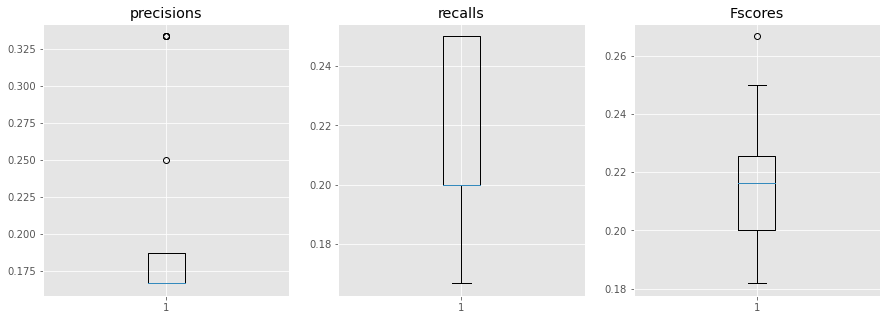

In [19]:
fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))
ax[0].boxplot(CV_scores["precisions"])
ax[0].set_title("precisions")
ax[1].boxplot(CV_scores["recalls"])
ax[1].set_title("recalls")
ax[2].boxplot(CV_scores["Fscores"])
ax[2].set_title("Fscores")
plt.show()

* It looks like the recommender has high F1 scores for baking related recipes.  
* The boxplots look a bit different than the traditional boxplots because we don't have a lot of data.  
* According to the boxplots, there isn't a particular cuisine for which the model performs terribly.